In [2]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from ephysvibe.stats import smetrics
import matplotlib.pyplot as plt

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [16]:
# Define parameters
areas = ["pfc"]
subject = "Riesling"
avgwin = 100
min_sp_sec = 1
n_test = 1
min_trials = 0
nonmatch = True  # if True: includes nonmatch trials
norm = False
zscore = True
# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400

# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# paths
filepaths = {
    "lip": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}
# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test

In [17]:
res = {"lip": {}, "v4": {}, "pfc": {}}
for area in areas:
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)
    data = Parallel(n_jobs=-1)(
        delayed(get_neuron_sample_test_fr)(
            path=path,
            time_before_sample=time_before_sample,
            time_before_test=time_before_test,
            idx_start_sample=idx_start_sample,
            idx_end_sample=idx_end_sample,
            idx_start_test=idx_start_test,
            idx_end_test=idx_end_test,
            n_test=n_test,
            min_trials=min_trials,
            min_neu=False,
            nonmatch=nonmatch,
            avgwin=avgwin,
            n_sp_sec=min_sp_sec,
            norm=norm,
            zscore=zscore,
            code=-1,
        )
        for path in tqdm(path_list)
    )

    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []
    for asc in data:
        fr = asc["fr"]
        if fr is not None:
            if np.all(np.isnan(fr["0"])):
                meanfr0 = np.full((fr["11"].shape[1]),np.nan)
            else:
                meanfr0 = np.mean(fr["0"], axis=0)
            meanfr11 = np.mean(fr["11"], axis=0)
            meanfr15 = np.mean(fr["15"], axis=0)
            meanfr51 = np.mean(fr["51"], axis=0)
            meanfr55 = np.mean(fr["55"], axis=0)
            s0mean.append(meanfr0)
            s11mean.append(meanfr11)
            s15mean.append(meanfr15)
            s51mean.append(meanfr51)
            s55mean.append(meanfr55)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean
    }
    to_python_hdf5(dat=[neufr], save_path='./' + area + "_population_mean_fr_out.h5")

100%|██████████| 2122/2122 [49:57<00:00,  1.41s/it]


In [12]:
areas

['v4']

(<Figure size 640x480 with 1 Axes>, <Axes: >)

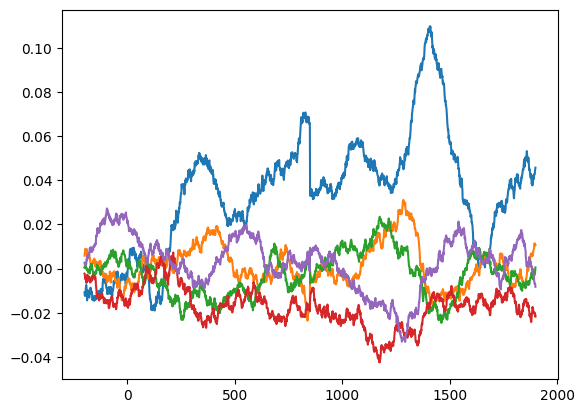

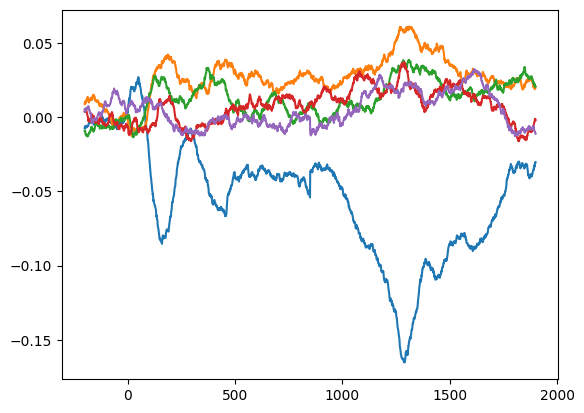

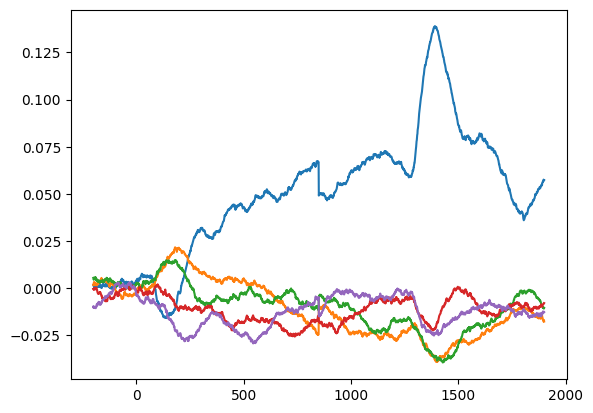

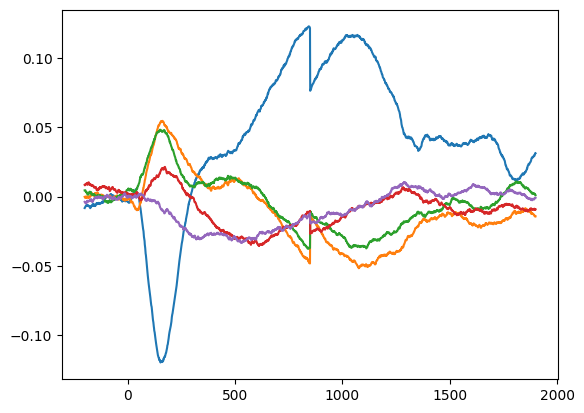

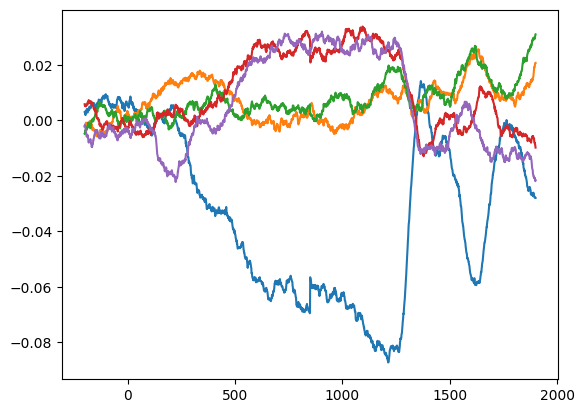

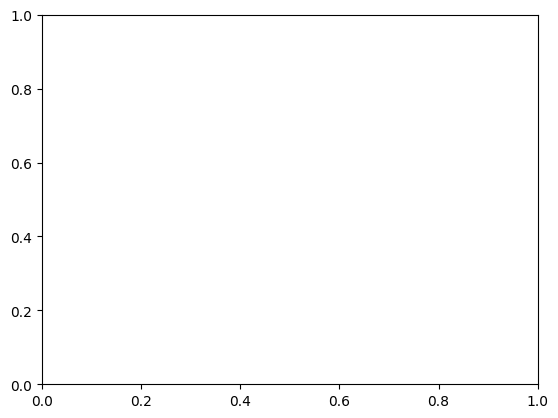

In [18]:
area='lip'
neufr=from_python_hdf5('./' + area + "_population_mean_fr_out.h5")[0]
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['0mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['11mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['15mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['51mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['55mean']),axis=0))
plt.subplots()
neufr=from_python_hdf5('./' + area + "_population_mean_fr_in.h5")[0]
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['0mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['11mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['15mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['51mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['55mean']),axis=0))
area='pfc'
neufr=from_python_hdf5('./' + area + "_population_mean_fr_out.h5")[0]
plt.subplots()
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['0mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['11mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['15mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['51mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['55mean']),axis=0))
plt.subplots()
neufr=from_python_hdf5('./' + area + "_population_mean_fr_in.h5")[0]
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['0mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['11mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['15mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['51mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['55mean']),axis=0))
area='v4'
neufr=from_python_hdf5('./' + area + "_population_mean_fr_out.h5")[0]
plt.subplots()
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['0mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['11mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['15mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['51mean']),axis=0))
plt.plot(np.arange(trial_dur)-200,np.nanmean(np.array(neufr['55mean']),axis=0))

In [ ]:
neufr['0mean'][0].shape

(2100,)

In [ ]:
neufr['0mean'][-1].shape

(1, 2100)

In [ ]:
s11mean[0]

array([-0.17815545, -0.17708412, -0.19232479, ...,  0.07928328,
        0.06916537,  0.0784379 ])